# Example of usage ImageAdaptiveTresholding transformer

## Install spark-ocr python packge

In [ ]:
%pip install ../dist/spark-ocr-0.0.1.tar.gz

## Initialization of spark session
Need specify path to `spark-ocr-assembly.jar` or `secret`

In [1]:
import os
os.environ['PYSPARK_PYTHON'] = "python3.7"

from pyspark.sql import SparkSession
from sparkocr import start

spark_ocr_jar_path = "../../target/scala-2.11"
spark = start(jar_path=spark_ocr_jar_path)
spark

SparkConf Configured, Starting to listen on port: 50624
JAR PATH:/usr/local/lib/python3.7/site-packages/sparkmonitor/listener.jar


## Import OCR transformers

In [2]:
from pyspark.ml import PipelineModel

from sparkocr.transformers import *
from sparkocr.utils import display_image

## Define OCR transformers and pipeline

In [132]:
binary_to_image = BinaryToImage() \
    .setInputCol("content") \
    .setOutputCol("image")

adaptive_thresholding = ImageAdaptiveThresholding() \
    .setInputCol("image") \
    .setOutputCol("corrected_image") \
    .setBlockSize(75) \
    .setOffset(70)

pipeline = PipelineModel(stages=[
    binary_to_image,
    adaptive_thresholding
])

## Read PDF document as binary file

In [4]:
import pkg_resources
image_example = "data/images/text_with_noise.png"
image_example_df = spark.read.format("binaryFile").load(image_example).cache()

## Run OCR pipelines

In [133]:
result = pipeline.transform(image_example_df).cache()

## Display results

Image:
        origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/images/text_with_noise.png 
        width: 1095
        height: 134
        mode: 10


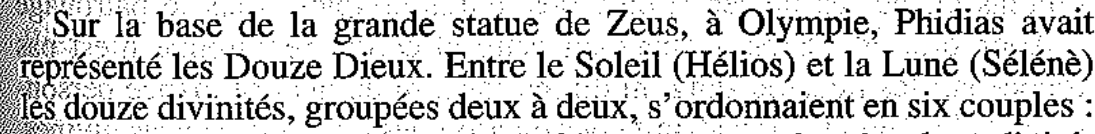

Image:
        origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/images/text_with_noise.png 
        width: 1095
        height: 134
        mode: 10


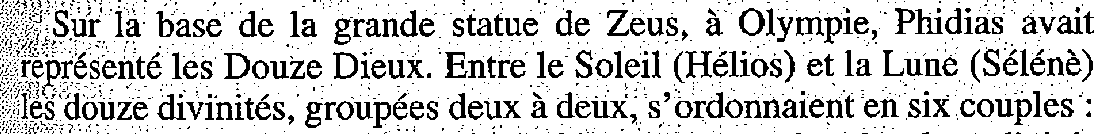

In [134]:
for r in result.select("image", "corrected_image").collect():
    display_image(r.image)
    display_image(r.corrected_image)